# DE LAGREVOL Regis & LI Ludovic

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import bokeh
import numpy as np
import tensorflow
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

### Dataset

In [8]:
data=pd.read_csv("SkillCraft1_Dataset.csv")
data

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.000000,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.000000,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.000000,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.000000,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.000000,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3390,10089,8,?,?,?,259.6296,0.020425,0.000743,9,0.000621,0.000146,0.004555,18.6059,42.8342,6.2754,46,0.000877,5,0.000000,0.000000
3391,10090,8,?,?,?,314.6700,0.028043,0.001157,10,0.000246,0.001083,0.004259,14.3023,36.1156,7.1965,16,0.000788,4,0.000000,0.000000
3392,10092,8,?,?,?,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
3393,10094,8,?,?,?,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631


### Nettoyage du dataset

In [9]:
data.replace("?",np.nan,inplace=True) 
data.dropna(inplace=True) # perte de 57 lignes, négligeable
data

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,9261,4,20,8,400,158.1390,0.013829,0.000504,7,0.000217,0.000313,0.003583,36.3990,66.2718,4.5097,30,0.001035,7,0.0,0.000287
3336,9264,5,16,56,1500,186.1320,0.006951,0.000360,6,0.000083,0.000166,0.005414,22.8615,34.7417,4.9309,38,0.001343,7,0.0,0.000388
3337,9265,4,21,8,100,121.6992,0.002956,0.000241,8,0.000055,0.000208,0.003690,35.5833,57.9585,5.4154,23,0.002014,7,0.0,0.000000
3338,9270,3,20,28,400,134.2848,0.005424,0.000182,5,0.000000,0.000480,0.003205,18.2927,62.4615,6.0202,18,0.000934,5,0.0,0.000000


In [10]:
data.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [11]:
data["Age"]=pd.to_numeric(data["Age"])
data["HoursPerWeek"]=pd.to_numeric(data["HoursPerWeek"])
data["TotalHours"]=pd.to_numeric(data["TotalHours"])

In [12]:
data.dtypes

GameID                    int64
LeagueIndex               int64
Age                       int64
HoursPerWeek              int64
TotalHours                int64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

### Matrice de corrélation

<AxesSubplot:>

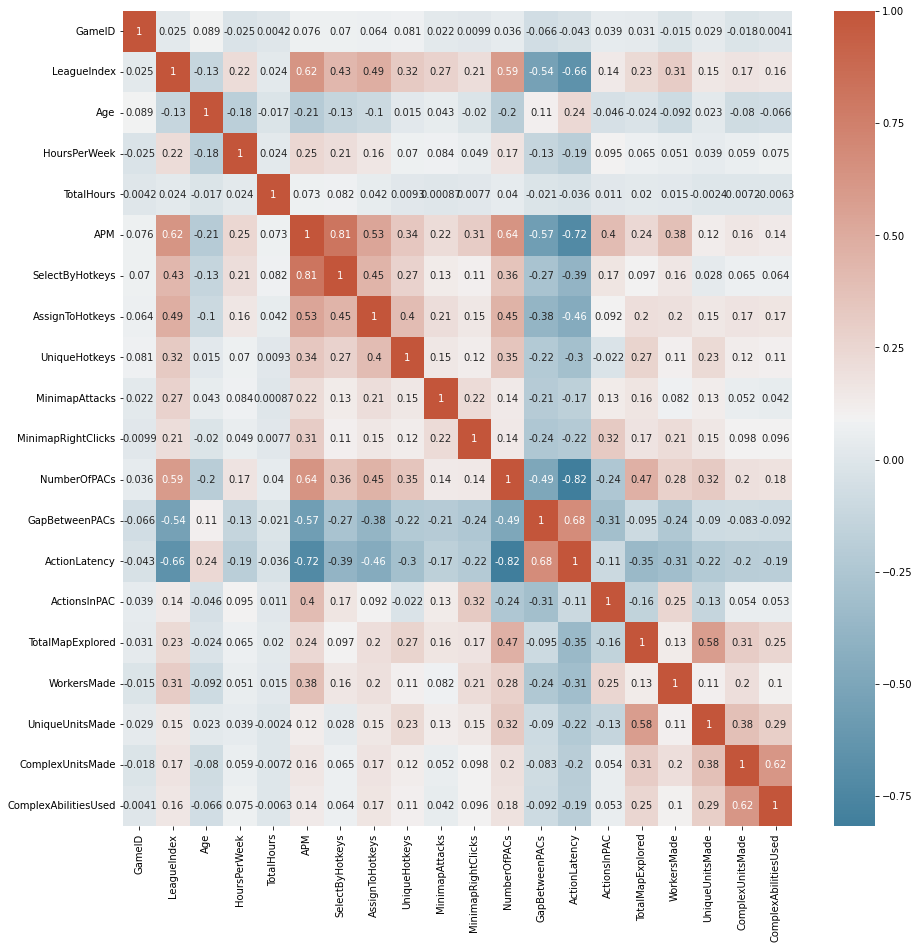

In [13]:
f, ax = plt.subplots(figsize=(15,15))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr=data.corr()
sns.heatmap(corr,cmap=cmap,xticklabels=corr.columns.values,yticklabels=corr.columns.values,ax=ax,annot=True)

### Treemap

In [14]:
fig=px.treemap(data,path=["LeagueIndex"],title="Nombre de joueurs par league")
fig.data[0].textinfo = 'label+value'
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
Df_withComplexUnitsMade_diferentfrom0=data.loc[data['ComplexUnitsMade'] <=0.2]

In [ ]:
Df_withComplexUnitsMade_diferentfrom0['LeagueIndex'].value_counts()

4    811
5    804
6    621
3    553
2    347
1    167
7     35
Name: LeagueIndex, dtype: int64

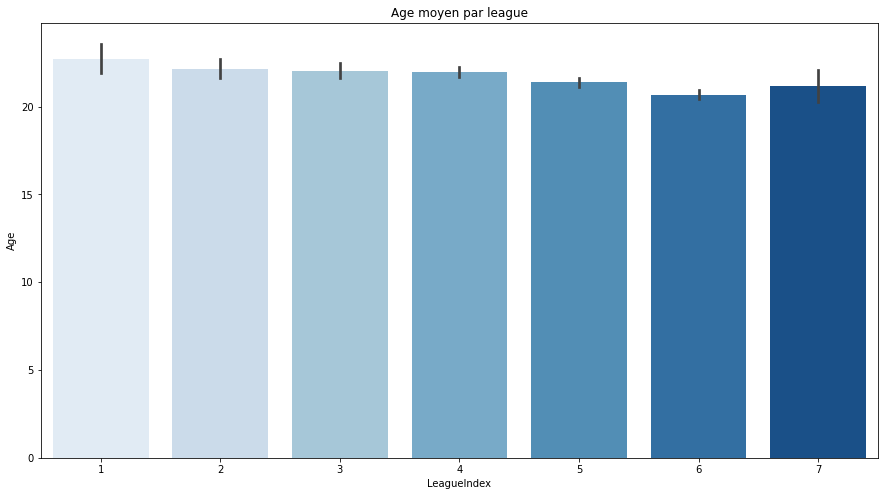

In [ ]:
f, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='LeagueIndex', y='Age', data=data, palette="Blues").set_title("Age moyen par league")
plt.show()

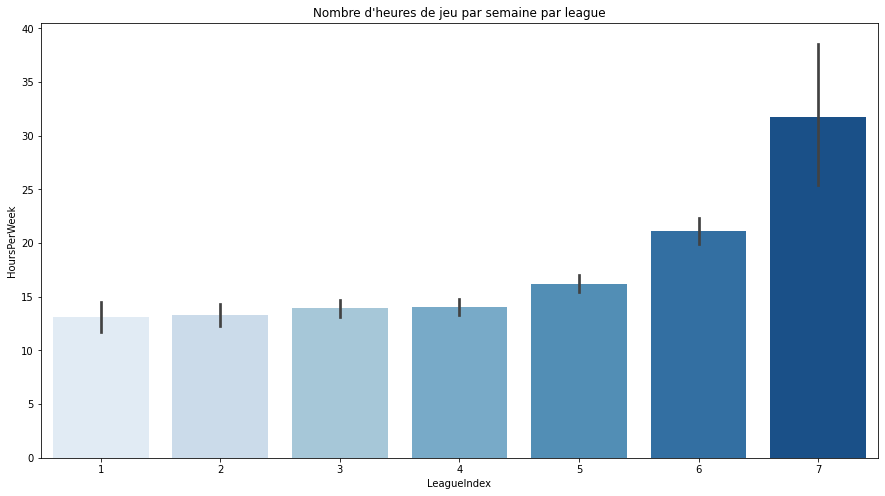

In [ ]:
f, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='LeagueIndex', y='HoursPerWeek', data=data, palette="Blues").set_title("Nombre d'heures de jeu moyen par semaine par league")
plt.show()

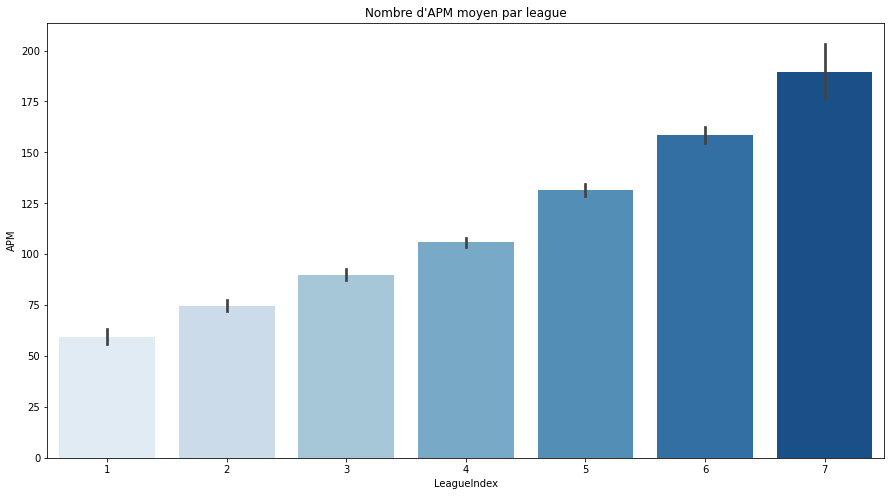

In [ ]:
f, ax = plt.subplots(figsize=(15,8))
sns.barplot(x='LeagueIndex', y='APM', data=data, palette="Blues").set_title("Nombre d'APM moyen par league")
plt.show()

### PCA

In [105]:
#Normalisation des données

scaler = MinMaxScaler()
Y_data=data["LeagueIndex"]
dataslace= scaler.fit_transform(data)
Df_dataslace=pd.DataFrame(dataslace,columns=data.columns)
Df_dataslace=Df_dataslace.drop(['GameID'], axis=1) # GameID nous sert à rien
Df_dataslace=Df_dataslace.drop(['LeagueIndex'], axis=1)
Df_dataslace

,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,0.392857,0.059524,0.002997,0.330799,0.081580,0.133287,0.7,0.036382,0.106386,0.571893,0.112814,0.106991,0.164167,0.433962,0.260161,0.363636,0.0,0.000000
1,0.250000,0.059524,0.004997,0.291411,0.076675,0.157412,0.4,0.097391,0.117265,0.497565,0.113906,0.116732,0.169772,0.320755,0.220120,0.272727,0.0,0.067312
2,0.500000,0.059524,0.000197,0.130248,0.025554,0.203586,0.4,0.097248,0.125122,0.308128,0.164793,0.334272,0.121319,0.320755,0.131610,0.363636,0.0,0.061212
3,0.107143,0.119048,0.000397,0.232595,0.023987,0.129286,0.1,0.017645,0.147358,0.425632,0.097857,0.191793,0.174137,0.264151,0.068848,0.454545,0.0,0.124390
4,0.571429,0.059524,0.000497,0.274168,0.026365,0.198584,0.2,0.000000,0.360271,0.231676,0.069516,0.246796,0.444035,0.188679,0.216374,0.181818,0.0,0.006244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3333,0.142857,0.047619,0.000397,0.370010,0.320956,0.306055,0.7,0.072017,0.084910,0.398330,0.129004,0.274412,0.149571,0.471698,0.188872,0.454545,0.0,0.093080
3334,0.000000,0.333333,0.001497,0.446126,0.161310,0.218402,0.6,0.027514,0.045056,0.649334,0.070267,0.066621,0.175069,0.622642,0.249594,0.454545,0.0,0.125719
3335,0.178571,0.047619,0.000097,0.270928,0.068603,0.146125,0.8,0.018130,0.056408,0.412872,0.125465,0.219626,0.204399,0.339623,0.381979,0.454545,0.0,0.000000
3336,0.142857,0.166667,0.000397,0.305149,0.125869,0.110204,0.5,0.000000,0.130183,0.346396,0.050443,0.249302,0.241010,0.245283,0.168997,0.272727,0.0,0.000000


In [106]:
Y_data=Y_data-1
Y_data

0       4
1       4
2       3
3       2
4       2
       ..
3335    3
3336    4
3337    3
3338    2
3339    3
Name: LeagueIndex, Length: 3338, dtype: int64

In [89]:
len(dataslace)

3338

In [17]:
#Analyse en composantes principales

pca=PCA(n_components=3)
pca_data=pca.fit_transform(Df_dataslace)
pca_data

array([[-0.29935845,  0.10885704, -0.13022382],
       [-0.11667195, -0.16656013, -0.04850436],
       [ 0.16495401,  0.07820358, -0.05288214],
       ...,
       [-0.17118549,  0.23860524, -0.17881845],
       [ 0.12141256, -0.00138136, -0.17373938],
       [ 0.20600373, -0.07025412,  0.17848758]])

In [ ]:
pca.explained_variance_ratio_

array([0.37057218, 0.13759345, 0.11090771])

### K-means

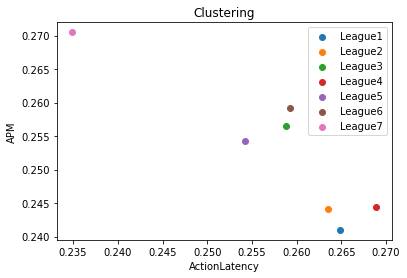

In [63]:
#cluster avec les deux metrique les plus represantative
for i in range(1,8):
    temp=Df_dataslace.loc[Df_dataslace["LeagueIndex"]==i]
    X=temp["ActionLatency"].mean()
    Y=temp["APM"].mean()
    plt.scatter(X, Y,label='League'+ str(i))


plt.legend()
plt.title('Clustering')
plt.xlabel('ActionLatency')
plt.ylabel('APM')
plt.show()

In [117]:
# ensure all data are floating point values
X=Df_dataslace
X = X.astype('float32')
y=Y_data
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# determine the number of input features
n_features = X_train.shape[1]
# define model
model = Sequential()
model.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(7, activation = 'relu'))
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

(2236, 18) (1102, 18) (2236,) (1102,)


In [118]:
# fit the model
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=1500, batch_size=10000)

Epoch 1/1500
1/1 [==============================] - 0s 471ms/step - loss: 9.1059 - accuracy: 0.0532 - val_loss: 7.8909 - val_accuracy: 0.0526
Epoch 2/1500
1/1 [==============================] - 0s 31ms/step - loss: 7.9526 - accuracy: 0.0555 - val_loss: 7.2089 - val_accuracy: 0.0508
Epoch 3/1500
1/1 [==============================] - 0s 27ms/step - loss: 7.2044 - accuracy: 0.0572 - val_loss: 6.8652 - val_accuracy: 0.0563
Epoch 4/1500
1/1 [==============================] - 0s 32ms/step - loss: 6.8916 - accuracy: 0.0595 - val_loss: 6.5932 - val_accuracy: 0.0535
Epoch 5/1500
1/1 [==============================] - 0s 29ms/step - loss: 6.6816 - accuracy: 0.0675 - val_loss: 6.4986 - val_accuracy: 0.0681
Epoch 6/1500
1/1 [==============================] - 0s 36ms/step - loss: 6.5938 - accuracy: 0.0792 - val_loss: 6.4132 - val_accuracy: 0.0744
Epoch 7/1500
1/1 [==============================] - 0s 30ms/step - loss: 6.5594 - accuracy: 0.0877 - val_loss: 6.3947 - val_accuracy: 0.0898
Epoch 8/1500